# Assignment 1
## ✅ Rename the filename with your roll number. E.g. if your roll number is `MT24003` then rename the file `MT24003_a1.ipynb`.
## ✅ Write code only in the sections marked with `# YOUR CODE HERE`. No, you can NOT write code anywhere else.
## ✅ Download and extract the `data.zip` folder next to this file. If you extract it correctly, you will have a `data` folder next to this file.
## ❌ Do not modify any other function or class definitions; doing so may lead to the autograder failing to judge your submission, resulting in a zero.
## ❌ Deleting or adding new cells may lead to the `autograder` failing to judge your submission, resulting in a zero. Even if a cell is empty, do NOT delete it.
## ❌ Do NOT install / import any other libraries. You should be able to solve all the questions using only the libraries imported below.


In [29]:
!pip install torch==2.1.2 torchvision==0.16.2 torchaudio==2.1.2 -q
!pip install numpy==1.25.2 -q
!pip install soundfile==0.13.0 -q
!pip install pandas==2.2.3 -q
!pip install matplotlib==3.9.4 -q

In [30]:
import os
import random
import timeit
from pathlib import Path
from typing import Tuple

import matplotlib.pyplot as plt
import pandas as pd
import torch
import torchaudio

In [31]:
PATH_TO_DATA_DIR = Path("./data")
PATH_TO_SPEECH_COMMANDS_DIR = str(PATH_TO_DATA_DIR / "speech_commands_v0.01")
PATH_TO_FASHION_MNIST_DIR = str(PATH_TO_DATA_DIR / "fashion-mnist")

# `q1`: `Fashion MNIST` and `Speech Commands` Datasets and DataLoaders
   
* `q1a`: Write a PyTorch-compatible `Dataset` class to load the Speech Command Dataset **without using any pre-built PyTorch utilities like `torch.utils.data.Dataset`**. Your task is to implement the functionality manually. The dataset class should read audio files at a specified sampling rate and output a tuple containing the audio as a PyTorch tensor and its corresponding class label. The class label should be encoded as an integer value (e.g., 1, 2, 3, ...) for all the 10 labels. For the audio data in `Speech Commands` dataset, you need to convert the audio waveforms to spectrograms. You can use the `torchaudio` library to achieve this. Feel free to do so in either the `Dataset` here, or in the `DataLoader` in the next question, or in the `collate_fn` function in the `DataLoader` in the next question. Find where it fits best in terms of latency and efficiency.

* `q1b`: Write a PyTorch-compatible `Dataset` class to load the Fashion MNIST dataset **without using any pre-built PyTorch utilities like `torch.utils.data.Dataset`**. Your task is to implement the functionality manually. The dataset class should read the CSV files containing the flattened image pixel values and output a tuple containing the image as a PyTorch tensor and its corresponding class label. The class label should be encoded as an integer value (e.g., 1, 2, 3, ...) for all the 10 labels.
* `q1c`: Write a PyTorch-compatible `DataLoader` class to create batches of data **without using any pre-built PyTorch utilities like `torch.utils.data.DataLoader`**. The `DataLoader` should:
  1. Take in a dataset object (that has `__len__` and `__getitem__`) and create batches of data with a specified batch size.
  2. Support shuffling of the dataset at the start of each epoch if specified.
  3. Be **modality-agnostic**, meaning it should work with any dataset type (e.g., images, text, or audio), provided the dataset follows the requirements mentioned in `q1` and `q2`.
  4. Ensure batches are created such that:
     - The number of batches is determined by the dataset size and batch size.
     - Remaining samples (if any) form the last batch, even if the batch is smaller than the specified size.
  5. Implement collate functions for both the modalities. You may need to use padding to stack audio tensors of different lengths.
*
* `q1d`: Code to benchmark your implementation of `DataLoader` with PyTorch's `DataLoader` is given. Compare the times and optimize your implementation to reduce the time taken to load the data. You don't have to write any code for this question, just tweak your implementation in `q1a`, `q1b`, and `q1c` based on the benchmarking results.

`q1` Grading [Total: 1 point]:
1. `q1a`: 0.2 points if the code runs without any errors on hidden test cases, otherwise 0 points. No partial points for this question.
2. `q1b`: 0.2 points if the code runs without any errors on hidden test cases, otherwise 0 points. No partial points for this question.
3. `q1c`: 0.1 points if the code runs without any errors on hidden test cases, otherwise 0 points. No partial points for this question.
4. `q1d`: 0.5 points. You will be awarded points based on the time taken by your implementation compared to PyTorch's `DataLoader`. The points will be awarded based on the output of `generate_benchmark_report` function. The points will be awarded as follows:
   1. 10% or less: 0.5 points
   2. 11% to  20%: 0.4 points
   3. 21% to  30%: 0.3 points
   4. 31% to  40%: 0.2 points
   5. 41% to  50%: 0.1 points
   6. 51% or more: 0.0 points

You are provided with the following template. **Populate only the sections marked as `# YOUR CODE HERE`. Do not modify other parts of the template.**

## `q1a`: Speech Commands Dataset

In [32]:
# q1a


class SpeechCommandDataset:
    def __init__(
        self, path_to_speech_commands_dataset, path_to_txt_file, audio_sample_rate
    ):
        """
        Initialize the dataset.

        Args:
            path_to_speech_commands_dataset (str): Path to the speech commands dataset.
            audio_sample_rate (int): Sample rate to resample audio to.
        """
        # YOUR CODE HERE
        self.path_to_speech_commands_dataset = path_to_speech_commands_dataset #data
        self.path_to_txt_file = path_to_txt_file #train test
        self.audio_sample_rate = audio_sample_rate

        with open(self.path_to_txt_file, "r") as f:
            self.audios = f.read().splitlines()

        self.spectrogram = torchaudio.transforms.MelSpectrogram(n_mels=40)#, normalized = True)
        self.resample = torchaudio.transforms.Resample(new_freq = self.audio_sample_rate)


        self.label_to_idx = {
            "bed": 0, "bird": 1, "cat": 2, "dog": 3,
            "down": 4, "eight": 5, "five": 6, "four": 7,
            "go": 8, "happy": 9
        }

    def __len__(self):
        """
        Return the number of samples in the dataset.
        """
        return len(self.audios)

    def __getitem__(self, index) -> Tuple[torch.Tensor, int]:
        """
        Retrieve the audio tensor and its class label for a given index.

        Args:
            index (int): Index of the sample to retrieve.

        Returns:
            (torch.Tensor, str): A tuple containing the audio tensor and class label.
        """
        # YOUR CODE HERE
        audio = self.audios[index]
        label_str = audio.split("/")[0]
        label = self.label_to_idx[label_str]

        waveform, sample_rate = torchaudio.load(os.path.join(self.path_to_speech_commands_dataset, audio))

        if sample_rate != self.audio_sample_rate:
            waveform = self.resample(waveform)

        spectrogram = self.spectrogram(waveform)


        # print(spectrogram.shape)

        return spectrogram, label # (channel, features, time)




In [33]:
# tests for q1a
train_speech_commands_dataset = SpeechCommandDataset(
    path_to_speech_commands_dataset=PATH_TO_SPEECH_COMMANDS_DIR,
    path_to_txt_file=Path(PATH_TO_SPEECH_COMMANDS_DIR) / "training_list.txt",
    audio_sample_rate=16_000,
)

del train_speech_commands_dataset

In [34]:
# tests for q1a
test_speech_commands_dataset = SpeechCommandDataset(
    path_to_speech_commands_dataset=PATH_TO_SPEECH_COMMANDS_DIR,
    path_to_txt_file=Path(PATH_TO_SPEECH_COMMANDS_DIR) / "testing_list.txt",
    audio_sample_rate=16_000,
)


del test_speech_commands_dataset

## `q1b`: Fashion MNIST Dataset

In [35]:
# q1b


class FashionMNISTDataset:
    def __init__(self, csv_file_path):
        """
        Initialize the dataset.

        Args:
            csv_file_path (str): Path to the CSV file containing the FashionMNIST data.
        """
        # YOUR CODE HERE
        self.csv_file_path = csv_file_path
        # print("hello")
        self.images = pd.read_csv(self.csv_file_path)
        # print("world")

    def __len__(self):
        """
        Return the number of samples in the dataset.
        """
        # YOUR CODE HERE
        return len(self.images)

    def __getitem__(self, index):
        """
        Retrieve the image tensor and its class label for a given index.

        Args:
            index (int): Index of the sample to retrieve.

        Returns:
            (torch.Tensor, int): A tuple containing the image tensor and label.
        """
        # YOUR CODE HERE
        row = self.images.iloc[index]
        flattened_image = row[1:].tolist()
        flattened_image = [i/255.0 for i in flattened_image]
        label = row[0]

        image = torch.tensor(flattened_image, dtype=torch.float32)
        image = image.reshape(28, 28).unsqueeze(0)


        return image,label

In [36]:
# tests for q1b
train_fashion_mnist_dataset = FashionMNISTDataset(
    csv_file_path=PATH_TO_FASHION_MNIST_DIR + "/fashion-mnist_train.csv"
)


del train_fashion_mnist_dataset

In [37]:
# tests for q1b
test_fashion_mnist_dataset = FashionMNISTDataset(
    csv_file_path=PATH_TO_FASHION_MNIST_DIR + "/fashion-mnist_test.csv"
)


del test_fashion_mnist_dataset

## `q1c`: DataLoader

In [38]:
# q1c


class DataLoader:
    def __init__(self, dataset, collate_fn, batch_size=1, shuffle=False):
        """
        Custom DataLoader implementation.

        Args:
            dataset (Dataset): The dataset to load data from.
            batch_size (int): Number of samples per batch.
            shuffle (bool): Whether to shuffle the dataset at the start of each epoch.
            collate_fn (callable): Function to collate samples into batches.
        """
        # YOUR CODE HERE
        self.dataset = dataset
        self.bs = batch_size
        self.shuffle = shuffle
        self.collate_fn = collate_fn
        self.ind = list(range(len(dataset)))
        self.curr=0

    def __iter__(self):
        """
        Creates an iterator over the dataset.

        Returns:
            DataLoader: The instance itself, prepared for iteration.
        """
        # YOUR CODE HERE

        self.curr = 0
        return self


    def __next__(self):
        """
        Fetch the next batch of data.

        Returns:
            A batch of samples collated by `collate_fn`.

        Raises:
            StopIteration: When all samples have been consumed.
        """
        # YOUR CODE HERE
        if self.curr>=len(self.ind):
            raise StopIteration

        start = self.curr
        end = min(self.curr+self.bs,len(self.ind))
        batches = self.ind[start:end]

        samples=[]

        for i in batches:
            samples.append(self.dataset[i])

        self.curr = end

        return self.collate_fn(samples)

    def __len__(self):
        """
        Returns the number of batches per epoch.

        Returns:
            int: Total number of batches.
        """
        # YOUR CODE HERE
        num = len(self.dataset) + self.bs - 1
        den = self.bs

        return num//den


def speech_collate_fn(batch):
    """
    Default collate function to stack tensors into a batch.
    You may need to use padding to stack audio tensors of different lengths.

    Args:
        batch (list): A list of tuples (data, label).

    Returns:
        tuple: A tuple of stacked data and label tensors.
    """
    # YOUR CODE HERE
    max_sample = 0
    tensor_list = [item[0] for item in batch] # (1, 201, 81) -> (channel, feature, ts)
    labels = [item[1] for item in batch]

    max_len = 0
    for i in tensor_list:
        max_len = max(max_len, i.shape[2])

    padded_list = []

    for i in tensor_list:
        padding = max_len - i.shape[2]
        paddedSample = torch.nn.functional.pad(i, (0,padding), 'constant', -100)
        padded_list.append(paddedSample)

    data_tensor =  torch.stack(padded_list, dim =0)
    label_tensor = torch.tensor(labels)
    x = (data_tensor,label_tensor)

    # print("shape", data_tensor.shape)
    return x


def image_collate_fn(batch):
    """
    Default collate function to stack tensors into a batch.

    Args:
        batch (list): A list of tuples (data, label).

    Returns:
        tuple: A tuple of stacked data and labels tensors.
    """
    # YOUR CODE HERE
    # print(batch)
    tensor_list = [item[0] for item in batch]
    labels = [item[1] for item in batch]

    data_tensor = torch.stack(tensor_list, dim=0)
    label_tensor = torch.tensor(labels)
    x = (data_tensor,label_tensor)
    return x


In [39]:
# tests for q1c

train_speech_commands_dataset = SpeechCommandDataset(
    path_to_speech_commands_dataset=PATH_TO_SPEECH_COMMANDS_DIR,
    path_to_txt_file=Path(PATH_TO_SPEECH_COMMANDS_DIR) / "training_list.txt",
    audio_sample_rate=16_000,
)

train_speech_commands_dataloader = DataLoader(
    dataset=train_speech_commands_dataset,
    collate_fn=speech_collate_fn,
    batch_size=4,
    shuffle=False,
)


del train_speech_commands_dataloader

In [40]:
# tests for q1c

train_fashion_mnist_dataset = FashionMNISTDataset(
    csv_file_path=PATH_TO_FASHION_MNIST_DIR + "/fashion-mnist_train.csv"
)

train_fashion_mnist_dataloader = DataLoader(
    dataset=train_fashion_mnist_dataset,
    collate_fn=image_collate_fn,
    batch_size=4,
    shuffle=False,
)



del train_fashion_mnist_dataloader

## `q1d`: Benchmarking

In [41]:
def run_dataloader_benchmark(datset, collate_fn, dataloader_class):
    dataloader = dataloader_class(
        dataset=datset, collate_fn=collate_fn, batch_size=64, shuffle=True
    )
    num_runs = 10
    time = timeit.timeit(lambda: list(iter(dataloader)), number=num_runs)
    return time


def generate_benchmark_report(dataset, custom_dataloader_class, collate_fn):
    pytorch_dataloader_time = run_dataloader_benchmark(
        dataset, collate_fn, torch.utils.data.DataLoader
    )
    custom_dataloader_time = run_dataloader_benchmark(
        dataset, collate_fn, custom_dataloader_class
    )

    if custom_dataloader_time < pytorch_dataloader_time:
        print(
            f"Your DataLoader is faster than PyTorch DataLoader: {custom_dataloader_time:.2f}s < {pytorch_dataloader_time:.2f}s"
        )

    elif custom_dataloader_time > pytorch_dataloader_time:
        slow_percentage = (
            (custom_dataloader_time - pytorch_dataloader_time) / custom_dataloader_time
        ) * 100
        print(
            f"Your DataLoader is {slow_percentage:.2f}% slower than PyTorch DataLoader: {custom_dataloader_time:.2f}s > {pytorch_dataloader_time:.2f}s"
        )

In [42]:
# tests for q1d

train_speech_commands_dataset = SpeechCommandDataset(
    path_to_speech_commands_dataset=PATH_TO_SPEECH_COMMANDS_DIR,
    path_to_txt_file=Path(PATH_TO_SPEECH_COMMANDS_DIR) / "training_list.txt",
    audio_sample_rate=16_000,
)

generate_benchmark_report(
    train_speech_commands_dataset, DataLoader, speech_collate_fn
)

del train_speech_commands_dataset

Your DataLoader is faster than PyTorch DataLoader: 88.68s < 90.46s


In [43]:
# tests for q1d

train_fashion_mnist_dataset = FashionMNISTDataset(
    csv_file_path=PATH_TO_FASHION_MNIST_DIR + "/fashion-mnist_train.csv"
)

generate_benchmark_report(
    train_fashion_mnist_dataset, DataLoader, image_collate_fn
)

del train_fashion_mnist_dataset

<ipython-input-35-4be5a8019c38>:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = row[0]


Your DataLoader is faster than PyTorch DataLoader: 133.24s < 161.38s


# `q2`: `MLP` Model
* `q2a`: Implement a multi-layer perceptron (MLP) model using PyTorch. Your goal is to minimize the width, depth, and count parameters while maximizing the model's performance on the test set of `Fashion MNIST` datasets. The model must satisfy the following constraints:
    1. Should be a simple feed-forward neural network (MLP).
    2. Maximum width: 512
    3. Maximum depth: 100
    4. Maximum epochs: 50
    5. Any activation function of your choice.
    6. The model should be designed for classification, i.e., the output should represent logits for each class.

* `q2b`: Implement a multi-layer perceptron (MLP) model using PyTorch. Your goal is to minimize the width, depth, and count parameters while maximizing the model's performance on the test set of `Speech Commands` datasets. The model must satisfy the following constraints:
    1. Should be a simple feed-forward neural network (MLP).
    2. Maximum width: 512
    3. Maximum depth: 100
    4. Maximum epochs: 50
    5. Any activation function of your choice.
    6. The model should be designed for classification, i.e., the output should represent logits for each class.

**Your best performance may come at a minimum which might be among class maximum.**

* `q2c`: You are provided with a skeleton code for the training loop. Your task is to complete the missing parts of the code to make the training loop work. This function will be used to train the models in `q2a`, `q2b`, `q3a`, and `q3b`. Specifically, you need to implement the following:
  1. **Training Loop**:
     - Zero gradients before the backward pass.
     - Perform a forward pass through the model.
     - Compute the loss using a suitable loss function.
     - Perform backpropagation (calculate gradients).
     - Update the model's parameters using an optimizer.   
  2. **Validation Loop**:
     - Perform a forward pass through the model on the validation data.
     - Calculate the loss and accuracy on the validation dataset.
  3. **Plotting**:
     - Plot the training and validation losses over the epochs.
     - Plot the training and validation accuracies over the epochs.
* `q2d`: Train the models in `q2a` and `q2b` using the training loop implemented in `q2c` and the dataloaders from `q1`. You don't have to write any code for this question, just optimize your implementation in `q2a`, `q2b`, and `q2c` based on the validation accuracy of the models.

`q2` Grading [Total: 2 point]:
1. `q2a`: 0.15 points if the code runs without any errors on hidden test cases, otherwise 0 points. No partial points for this question.
2. `q2b`: 0.15 points if the code runs without any errors on hidden test cases, otherwise 0 points. No partial points for this question.
3. `q2c`: 0.2 points if the code runs without any errors on hidden test cases, otherwise 0 points. No partial points for this question.
4. `q2d`: 1.5 points. You will be awarded points based on the validation accuracy of the models.
   1. For `MLP4SpeechCommands`:
      1. 80% or more: 0.75 points
      2. 60% to 79%: 0.5 points
      3. 40% to 59%: 0.25 points
      4. Less than 40%: 0 points
   2. For `MLP4FashionMNIST`:
      1. 95% or more: 0.75 points
      2. 90% to 94%: 0.5 points
      3. 85% to 89%: 0.25 points
      4. Less than 85%: 0 points

You are provided with the following template. **Populate only the sections marked as `# YOUR CODE HERE`. Do not modify other parts of the template.**

## `q2a`: MLP for Speech Commands Dataset

In [44]:
# q2a


class MLP4SpeechCommands(torch.nn.Module):
    def __init__(self, input_dim, num_classes):
        """
        Multi-Layer Perceptron for Speech Command Classification.

        Args:
            input_dim (int): Dimension of the input features.
            num_classes (int): Number of classes for classification.
        """
        super(MLP4SpeechCommands, self).__init__()



        self.l1 = torch.nn.Linear(input_dim, 512)
        self.l2 = torch.nn.Linear(512,256)
        self.l3 = torch.nn.Linear(256, num_classes)

        self.activation = torch.nn.ReLU()
        self.tanh = torch.nn.Tanh()

    def forward(self, x):
        """
        Forward pass for the model.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, input_dim).

        Returns:
            torch.Tensor: Logits of shape (batch_size, num_classes).
        """
        # YOUR CODE HERE
        x = x.view(x.size(0), -1)

        x = self.l1(x)
        x = self.activation(x)

        x = self.l2(x)
        x = self.tanh(x)

        x = self.l3(x)

        return x



In [45]:
# tests for q2a



## `q2b`: MLP for Fashion MNIST Dataset

In [46]:
# q2b


class MLP4FashionMNIST(torch.nn.Module):
    def __init__(self, input_dim, num_classes):
        """
        Multi-Layer Perceptron for FashionMNIST Image Classification.

        Args:
            input_dim (int): Dimension of the input features.
            num_classes (int): Number of classes for classification.
        """
        super(MLP4FashionMNIST, self).__init__()
        # YOUR CODE HERE
        self.l1 = torch.nn.Linear(input_dim, 500)
        self.l2 = torch.nn.Linear(500, num_classes)

        self.activation = torch.nn.ReLU()
        self.tanh = torch.nn.Tanh()

    def forward(self, x):
        """
        Forward pass for the model.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, input_dim).

        Returns:
            torch.Tensor: Logits of shape (batch_size, num_classes).
        """
        x = x.view(x.size(0), -1)
        x = self.l1(x)
        x = self.activation(x)

        x = self.l2(x)
        # x = self.tanh(x)

        # x = self.l3(x)
        # x = self.activation(x)

        # x = self.l4(x)

        return x


In [47]:
# tests for q2b



## `q2c`: Training Loop Function

In [48]:
# q2c


def train(
    model, train_loader, val_loader, num_epochs=10, lr=0.001, plot_save_path=None
):
    """
    A simple training loop.

    Args:
        model (torch.nn.Module): The model to train.
        train_loader (DataLoader): The DataLoader for the training set.
        val_loader (DataLoader): The DataLoader for the validation set.
        num_epochs (int): The number of epochs to train for.
        lr (float): The learning rate for the optimizer.
        plot_save_path (str or None): Path to save the loss plot. If None, plot will not be saved.

    Returns:
        None: This function will print the losses and plot them.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    ce_loss = torch.nn.CrossEntropyLoss()#weight=class_weights.to(device))
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        correct_train = 0
        total_train = 0


        # Training loop
        for inputs, labels in train_loader:

            inputs, labels = inputs.to(device), labels.to(device)
            # model_outputs = None
            # loss = None
            # YOUR CODE HERE
            model_outputs = model(inputs)
            loss = ce_loss(model_outputs,labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()


            train_loss += loss.item() * inputs.size(0)  # Accumulate the loss
            _, predicted = torch.max(model_outputs, 1)  # Get the predicted class
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)

        # bookkeeping of losses
        avg_train_loss = train_loss / total_train
        train_losses.append(avg_train_loss)

        # Validation loop
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():  # No need to calculate gradients for validation
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                # model_outputs = None
                # YOUR CODE HERE
                model_outputs = model(inputs)
                # raise NotImplementedError()
                val_loss += ce_loss(model_outputs, labels).item() * inputs.size(0)  # Accumulate the loss
                _, predicted = torch.max(model_outputs, 1)  # Get the predicted class
                correct_val += (predicted == labels).sum().item()
                total_val += labels.size(0)

        avg_val_loss = val_loss / total_val
        val_losses.append(avg_val_loss)

        print(f"Epoch [{epoch + 1}/{num_epochs}]")
        print(
            f"Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}"
        )

        train_accuracy = 100 * correct_train / total_train
        train_accuracies.append(train_accuracy)
        print(f"Training Accuracy: {train_accuracy:.2f}%")

        val_accuracy = 100 * correct_val / total_val
        val_accuracies.append(val_accuracy)
        print(f"Validation Accuracy: {val_accuracy:.2f}%")

    # Plot the losses and accuracies accross epochs in 2 subplots
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Loss per Epoch")
    plt.plot(train_losses, label="Train Loss", color="blue")
    plt.plot(val_losses, label="Val loss", color = "red")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()


    plt.subplot(1, 2, 2)
    plt.title("Accuracy per Epoch")
    # YOUR CODE HERE
    plt.plot(train_accuracies, label="Train Acc", color="blue")
    plt.plot(val_accuracies, label="Val Acc", color = "red")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    if plot_save_path:
        plt.savefig(plot_save_path)
    plt.show()

In [49]:
# tests for q2c



In [50]:
# tests for q2c


## `q2d`: Training

Epoch [1/50]
Training Loss: 4.2880, Validation Loss: 2.5089
Training Accuracy: 7.59%
Validation Accuracy: 19.49%
Epoch [2/50]
Training Loss: 2.9810, Validation Loss: 2.2787
Training Accuracy: 0.46%
Validation Accuracy: 19.35%
Epoch [3/50]
Training Loss: 2.7668, Validation Loss: 2.2231
Training Accuracy: 1.98%
Validation Accuracy: 20.14%
Epoch [4/50]
Training Loss: 2.6920, Validation Loss: 2.1421
Training Accuracy: 4.92%
Validation Accuracy: 22.38%
Epoch [5/50]
Training Loss: 2.5825, Validation Loss: 2.0685
Training Accuracy: 7.26%
Validation Accuracy: 24.10%
Epoch [6/50]
Training Loss: 2.4175, Validation Loss: 2.0027
Training Accuracy: 10.76%
Validation Accuracy: 27.37%
Epoch [7/50]
Training Loss: 2.3018, Validation Loss: 1.9446
Training Accuracy: 13.84%
Validation Accuracy: 28.95%
Epoch [8/50]
Training Loss: 2.1660, Validation Loss: 1.9062
Training Accuracy: 18.99%
Validation Accuracy: 31.05%
Epoch [9/50]
Training Loss: 2.0450, Validation Loss: 1.9146
Training Accuracy: 22.67%
Validat

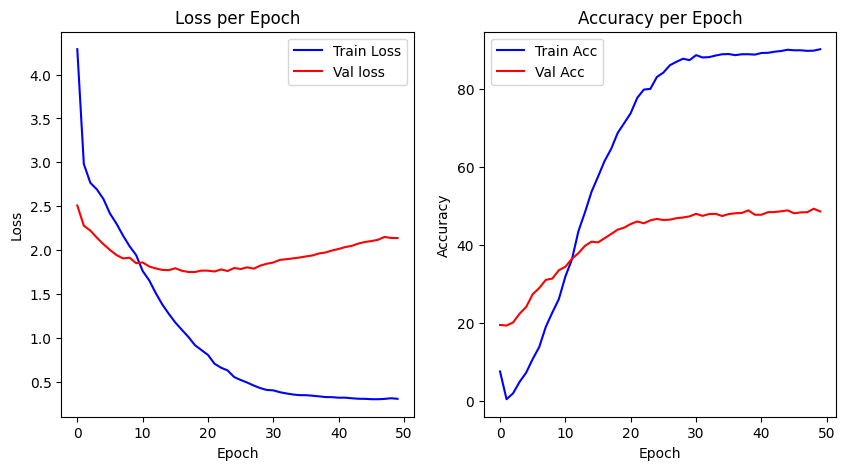

In [51]:
# tests for q2d

batch_size: int
num_epochs: int
mlp_input_dim: int
learning_rate: float
example_hyper_parameter: int

# Define the hyperparameters
example_hyper_parameter = 1024 # example: this is how you should define the hyperparameters
# YOUR CODE HERE
batch_size = 32
num_epochs = 50
mlp_input_dim = 40*81
learning_rate = 5e-4

assert num_epochs <= 50, "num_epochs should be less than or equal to 50"

train_speech_commands_dataset = SpeechCommandDataset(
    path_to_speech_commands_dataset=PATH_TO_SPEECH_COMMANDS_DIR,
    path_to_txt_file=Path(PATH_TO_SPEECH_COMMANDS_DIR) / "training_list.txt",
    audio_sample_rate=16_000,
)

test_speech_commands_dataset = SpeechCommandDataset(
    path_to_speech_commands_dataset=PATH_TO_SPEECH_COMMANDS_DIR,
    path_to_txt_file=Path(PATH_TO_SPEECH_COMMANDS_DIR) / "testing_list.txt",
    audio_sample_rate=16_000,
)

train_speech_commands_dataloader = DataLoader(
    dataset=train_speech_commands_dataset,
    collate_fn=speech_collate_fn,
    batch_size=batch_size,
    shuffle=True,
)

test_speech_commands_dataloader = DataLoader(
    dataset=test_speech_commands_dataset,
    collate_fn=speech_collate_fn,
    batch_size=batch_size,
    shuffle=False,
)



mlp_model = MLP4SpeechCommands(input_dim=mlp_input_dim, num_classes=10)
train(
    mlp_model,
    train_speech_commands_dataloader,
    test_speech_commands_dataloader,
    num_epochs=num_epochs,
    lr=learning_rate,
    plot_save_path=None,
)

<ipython-input-35-4be5a8019c38>:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = row[0]


Epoch [1/50]
Training Loss: 0.6613, Validation Loss: 0.4942
Training Accuracy: 78.52%
Validation Accuracy: 83.41%
Epoch [2/50]
Training Loss: 0.4551, Validation Loss: 0.4370
Training Accuracy: 84.25%
Validation Accuracy: 84.94%
Epoch [3/50]
Training Loss: 0.4132, Validation Loss: 0.4075
Training Accuracy: 85.53%
Validation Accuracy: 85.82%
Epoch [4/50]
Training Loss: 0.3872, Validation Loss: 0.3873
Training Accuracy: 86.36%
Validation Accuracy: 86.48%
Epoch [5/50]
Training Loss: 0.3678, Validation Loss: 0.3727
Training Accuracy: 87.08%
Validation Accuracy: 86.85%
Epoch [6/50]
Training Loss: 0.3523, Validation Loss: 0.3615
Training Accuracy: 87.61%
Validation Accuracy: 87.03%
Epoch [7/50]
Training Loss: 0.3391, Validation Loss: 0.3521
Training Accuracy: 88.03%
Validation Accuracy: 87.27%
Epoch [8/50]
Training Loss: 0.3276, Validation Loss: 0.3444
Training Accuracy: 88.34%
Validation Accuracy: 87.40%
Epoch [9/50]
Training Loss: 0.3172, Validation Loss: 0.3381
Training Accuracy: 88.71%
Va

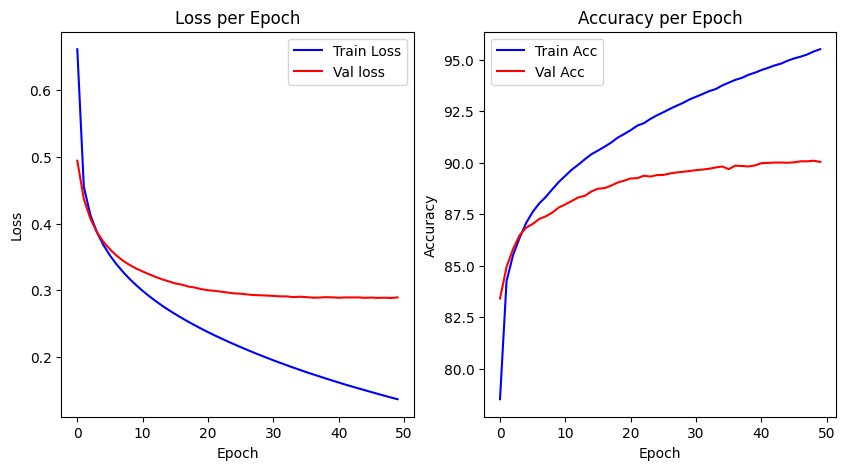

In [52]:
# tests for q2d

batch_size: int
num_epochs: int
mlp_input_dim: int
learning_rate: float
example_hyper_parameter: int

# Define the hyperparameters
example_hyper_parameter = 1024 # example: this is how you should define the hyperparameters
# YOUR CODE HERE
batch_size = 32 # 32
num_epochs = 50
mlp_input_dim = 28*28
learning_rate = 1e-4 # 5e-4

random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.backends.cudnn.deterministic = True

assert num_epochs <= 50, "num_epochs should be less than or equal to 50"

train_fashion_mnist_dataset = FashionMNISTDataset(
    csv_file_path=PATH_TO_FASHION_MNIST_DIR + "/fashion-mnist_train.csv"
)
train_fashion_mnist_dataloader = DataLoader(
    dataset=train_fashion_mnist_dataset,
    collate_fn=image_collate_fn,
    batch_size=batch_size,
    shuffle=True,
)

test_fashion_mnist_dataset = FashionMNISTDataset(
    csv_file_path=PATH_TO_FASHION_MNIST_DIR + "/fashion-mnist_test.csv"
)
test_fashion_mnist_dataloader = DataLoader(
    dataset=test_fashion_mnist_dataset,
    collate_fn=image_collate_fn,
    batch_size=batch_size,
    shuffle=False,
)

mlp_model = MLP4FashionMNIST(input_dim=mlp_input_dim, num_classes=10)

train(
    mlp_model,
    train_fashion_mnist_dataloader,
    test_fashion_mnist_dataloader,
    num_epochs=num_epochs,
    lr=learning_rate,
    plot_save_path=None,
)

# `q3`: `CNN` Model

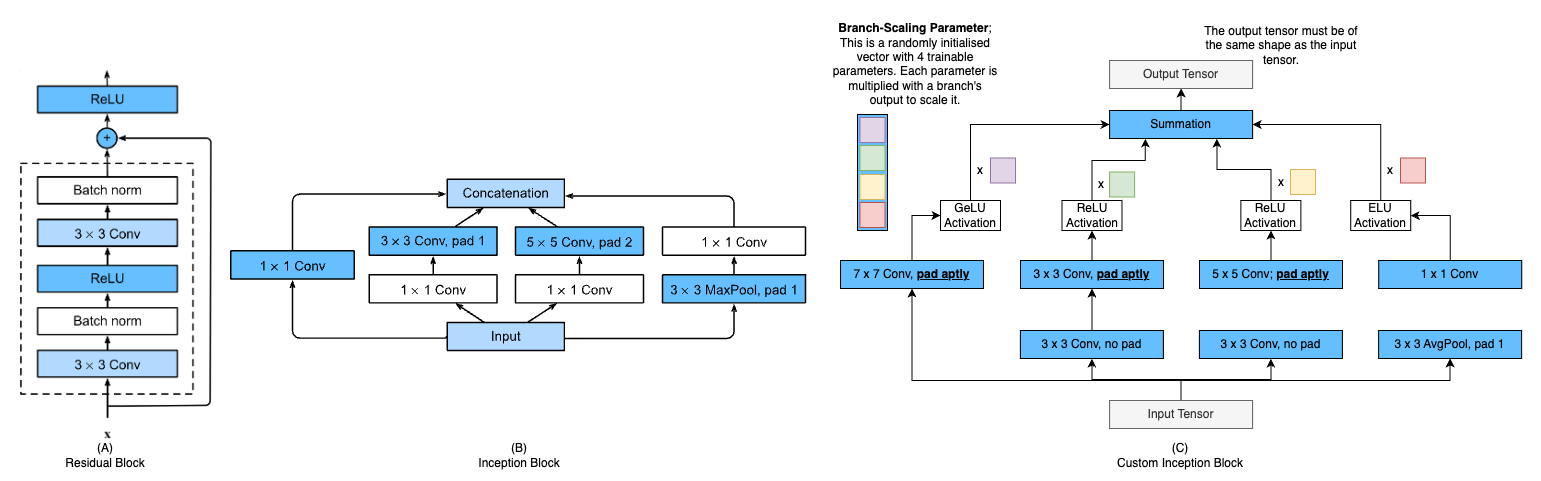


### ResNet Block
In the figure, (A) represents a single `ResNet` block. The `Residual` / `ResNet` block in ResNet models consists of two 3x3 Conv layers with Batch Norm and activation activation. The block adds the input (`X`) to the processed output of the layers in the dotted box, creating a shortcut that facilitates effective training in deep networks. This skip connection helps address vanishing gradient issues. You can read more about `ResNet Blocks` here: [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385).

### Inception Block
In the figure, (B) represents a single `Inception` block. The `Inception` block uses four branches to process input in parallel. Branch 1 consists of a single 1x1 Conv. Branch 2 applies a 1x1 Conv followed by a 3x3 Conv. Branch 3 uses a 1x1 Conv followed by a 5x5 Conv. Branch 4 performs 3x3 Max Pooling followed by a 1x1 Conv. The outputs from all branches are concatenated along the channel dimension, enabling multi-scale feature extraction. You can read more about `Inception Blocks` here: [Going Deeper with Convolutions](https://arxiv.org/abs/1409.4842).

* `q3a`: Implement the `CustomInceptionBlock` class as shown in the the figure (C). You need to find apt padding values for each convolution layer so that the input and output tensor have the same shape.

* `q3b`: CNN for Speech Commands
  1. Design a custom network using the following combination of blocks, adhering to configurations shown in the figure above.
  2. Network Architecture
     1. **Input Layer**
     2. **Residual Block × 2**
     3. **Inception Block × 2**
     4.  **Classification Network**
         - The **Classification Network** refers to a combination of either `nn.Linear` or `nn.Conv2d` layer that produce logits for the classification task.
  3. Constraints
     * Apart from the modules mentioned above, you can use `torch.nn.BatchNorm2d`, `torch.nn.Dropout`, and any activation functions.
     * The input to this network must be a spectrogram, and the output must be a class label. You can not pass in a raw waveform as input.
     * The network must strictly follow the architecture defined above.
     * You can train the NN to a maximum of 50 epochs.
     * Either Implement the `ResNetBlock` and `InceptionBlock` from scratch using the figure as reference or use pre-built PyTorch modules for these blocks.

* `q3c`: CNN for FashionMNIST
  1. Design a custom network using the following combination of blocks, adhering to configurations shown in the figure above.
  2. Network Architecture
     1. **Input Layer**
     2. **Residual Block × 2**
     3. **Inception Block × 2**
     4.  **Classification Network**
         - The **Classification Network** refers to a combination of either `nn.Linear` or `nn.Conv2d` layer that produce logits for the classification task.
  3. Constraints
     * Apart from the modules mentioned above, you can use `torch.nn.BatchNorm2d`, `torch.nn.Dropout`, and any activation functions.
     * The input to this network must be a FashionMNIST image, and the output must be a class label.
     * The network must strictly follow the architecture defined above.
     * You can train the NN to a maximum of 50 epochs.
     * Either Implement the `ResNetBlock` and `InceptionBlock` from scratch using the figure as reference or use pre-built PyTorch modules for these blocks.

* `q3d`: Train the models in `q3a` and `q3b` using the training loop implemented in `q3c` and the dataloaders from `q1`. You don't have to write any code for this question, just tweak your implementation in `q3a`, `q3b`, and `q3c` based on the validation accuracy of the models.

`q3` Grading [Total: 2 point]:
1. `q3a`: `CustomInceptionBlock` 0.2 points if the code runs without any errors on hidden test cases, otherwise 0 points. No partial points for this question.
2. `q3b`: 0.15 points if the code runs without any errors on hidden test cases, otherwise 0 points. No partial points for this question.
3. `q3c`: 0.15 points if the code runs without any errors on hidden test cases, otherwise 0 points. No partial points for this question.
4. `q3d`: 1.5 points. You will be awarded points based on the validation accuracy of the models.
   1. For `MLP4SpeechCommands`:
      1. 80% or more: 0.75 points
      2. 60% to 79%: 0.5 points
      3. 40% to 59%: 0.25 points
      4. Less than 40%: 0 points
   2. For `MLP4FashionMNIST`:
      1. 95% or more: 0.75 points
      2. 90% to 94%: 0.5 points
      3. 85% to 89%: 0.25 points
      4. Less than 85%: 0 points

You are provided with the following template. **Populate only the sections marked as `# YOUR CODE HERE`. Do not modify other parts of the template.**

## `q3a`: `CustomInceptionBlock` Implementation

In [53]:
class CustomInceptionBlock2D(torch.nn.Module):
    def __init__(self, input_channels, output_channels):
        super(CustomInceptionBlock2D, self).__init__()

        self.branch1_conv = torch.nn.Conv2d(input_channels, output_channels, kernel_size=7, padding=3)
        self.branch1_activation = torch.nn.GELU()

        self.branch2_conv1 = torch.nn.Conv2d(input_channels, output_channels, kernel_size=3)
        self.branch2_conv2 = torch.nn.Conv2d(output_channels, output_channels, kernel_size=3, padding=1)
        self.branch2_activation = torch.nn.ReLU()

        self.branch3_conv1 = torch.nn.Conv2d(input_channels, output_channels, kernel_size=3)
        self.branch3_conv2 = torch.nn.Conv2d(output_channels, output_channels, kernel_size=5, padding=2)
        self.branch3_activation = torch.nn.ReLU()

        self.branch4_pool = torch.nn.AvgPool2d(3, stride=1, padding=1)
        self.branch4_conv = torch.nn.Conv2d(input_channels, output_channels, kernel_size=1)
        self.branch4_activation = torch.nn.ELU()

        self.scale_params = torch.nn.Parameter(torch.rand(4))

    def forward(self, x):
        branch1 = self.branch1_activation(self.branch1_conv(x)) * self.scale_params[0]

        branch2 = self.branch2_conv1(x)
        branch2 = self.branch2_conv2(branch2)
        branch2 = self.branch2_activation(branch2) * self.scale_params[1]

        branch3 = self.branch3_conv1(x)
        branch3 = self.branch3_conv2(branch3)
        branch3 = self.branch3_activation(branch3) * self.scale_params[2]

        branch4 = self.branch4_pool(x)
        branch4 = self.branch4_activation(self.branch4_conv(branch4)) * self.scale_params[3]

        output = torch.cat([branch1, branch2, branch3, branch4], dim=1)
        return output


In [54]:
# Test for q3a


## `q3b`: CNN for Speech Commands Dataset

In [55]:
# Use this code cell to paste your implementation of the ResNetBlock and InceptionBlock classes
# NOTE: these implementations are not graded but will be used in the subsequent CNN models
# YOUR CODE HERE
class ResidualBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = torch.nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = torch.nn.BatchNorm2d(out_channels)
        self.relu = torch.nn.ReLU()
        self.conv2 = torch.nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = torch.nn.BatchNorm2d(out_channels)

        self.shortcut_conv = None
        self.shortcut_bn = None
        if stride > 1 or in_channels != out_channels:
            self.shortcut_conv = torch.nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, padding=0)
            self.shortcut_bn = torch.nn.BatchNorm2d(out_channels)

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)

        if self.shortcut_conv and self.shortcut_bn:
            residual = self.shortcut_conv(residual)
            residual = self.shortcut_bn(residual)

        out += residual
        out = self.relu(out)
        return out


class InceptionBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(InceptionBlock, self).__init__()

        self.branch1_conv = torch.nn.Conv2d(in_channels, out_channels, kernel_size=1)

        self.branch2_conv1 = torch.nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.branch2_conv2 = torch.nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)

        self.branch3_conv1 = torch.nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.branch3_conv2 = torch.nn.Conv2d(out_channels, out_channels, kernel_size=5, padding=2)

        self.branch4_pool = torch.nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.branch4_conv = torch.nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        branch1_out = self.branch1_conv(x)

        branch2_out = self.branch2_conv1(x)
        branch2_out = self.branch2_conv2(branch2_out)

        branch3_out = self.branch3_conv1(x)
        branch3_out = self.branch3_conv2(branch3_out)

        branch4_out = self.branch4_pool(x)
        branch4_out = self.branch4_conv(branch4_out)

        outputs = [branch1_out, branch2_out, branch3_out, branch4_out]
        return torch.cat(outputs, 1)


In [56]:
# q3b


class CNN4SpeechCommands(torch.nn.Module):
    def __init__(self, in_channels, num_classes):
        super(CNN4SpeechCommands, self).__init__()

        self.input_conv = torch.nn.Conv2d(in_channels, 16, kernel_size=1)

        self.res_block1 = ResidualBlock(16, 32, stride=2)  # stride 2
        self.res_block2 = ResidualBlock(32, 64, stride=2)  # stride 2

        self.inception1 = InceptionBlock(64, 64)
        self.inception2 = InceptionBlock(64 * 4, 64)

        self.c_conv1 = torch.nn.Conv2d(in_channels=256, out_channels=32, kernel_size=1, stride=1)
        self.c_activation1 = torch.nn.LeakyReLU()
        self.c_dropout1 = torch.nn.Dropout(0.4)

        self.c_conv2 = torch.nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.c_activation2 = torch.nn.LeakyReLU()
        self.c_dropout2 = torch.nn.Dropout(0.1)

        self.flatten = torch.nn.Flatten()
        self.l1 = torch.nn.Linear(3360, 512)
        self.activation1 = torch.nn.LeakyReLU()
        self.dropout = torch.nn.Dropout(0.2)
        self.l2 = torch.nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.input_conv(x)

        x = self.res_block1(x)
        x = self.res_block2(x)

        x = self.inception1(x)
        x = self.inception2(x)

        x = self.c_conv1(x)
        x = self.c_activation1(x)
        x = self.c_dropout1(x)

        x = self.c_conv2(x)
        x = self.c_activation2(x)
        x = self.c_dropout2(x)

        x = self.flatten(x)
        x = self.l1(x)
        x = self.activation1(x)
        x = self.dropout(x)
        x = self.l2(x)

        return x

In [57]:
# tests for q3b


## `q3c`: CNN for FashionMNIST Dataset

In [66]:
# q3c

class CNN4FashionMNIST(torch.nn.Module):
    def __init__(self, in_channels, num_classes):
        super(CNN4FashionMNIST, self).__init__()
        self.input_conv_conv = torch.nn.Conv2d(in_channels, 16, kernel_size=1)
        self.input_conv_bn = torch.nn.BatchNorm2d(16)
        self.input_conv_activation = torch.nn.LeakyReLU()

        self.res_block1 = ResidualBlock(16, 16)  # stride 2
        self.res_block2 = ResidualBlock(16, 16)  # stride 2

        self.inception1 = InceptionBlock(16, 32)
        self.inception2 = InceptionBlock(32 * 4, 32)


        self.c_conv1 = torch.nn.Conv2d(in_channels=128, out_channels=256, kernel_size=1, stride=2)
        self.c_bn1 = torch.nn.BatchNorm2d(256)
        self.c_activation1 = torch.nn.LeakyReLU()
        self.c_dropout1 = torch.nn.Dropout(0.25)

        self.c_conv2 = torch.nn.Conv2d(in_channels=256, out_channels=512, kernel_size=1, stride=3)
        self.c_bn2 = torch.nn.BatchNorm2d(512)
        self.c_activation2 = torch.nn.LeakyReLU()
        self.c_dropout2 = torch.nn.Dropout(0.25)

        self.c_conv3 = torch.nn.Conv2d(in_channels=512, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.c_activation3 = torch.nn.LeakyReLU()
        self.c_dropout3 = torch.nn.Dropout(0.25)

        self.flatten = torch.nn.Flatten()
        self.l1 = torch.nn.Linear(3200, 512)
        self.dropout = torch.nn.Dropout(0.4)
        self.activation = torch.nn.LeakyReLU()
        self.l2 = torch.nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.input_conv_conv(x)
        x = self.input_conv_bn(x)
        x = self.input_conv_activation(x)

        x = self.res_block1(x)
        x = self.res_block2(x)

        x = self.inception1(x)
        x = self.inception2(x)

        x = self.c_conv1(x)
        x = self.c_bn1(x)
        x = self.c_activation1(x)
        x = self.c_dropout1(x)

        x = self.c_conv2(x)
        x = self.c_bn2(x)
        x = self.c_activation2(x)
        x = self.c_dropout2(x)

        x = self.c_conv3(x)
        x = self.c_activation3(x)
        x = self.c_dropout3(x)

        x = self.flatten(x)
        x = self.l1(x)
        x = self.dropout(x)
        x = self.activation(x)
        x = self.l2(x)

        return x


In [59]:
# q3c


## `q3d`: Training the models

Epoch [1/50]
Training Loss: 2.3300, Validation Loss: 2.3003
Training Accuracy: 2.25%
Validation Accuracy: 12.12%
Epoch [2/50]
Training Loss: 2.3150, Validation Loss: 2.3017
Training Accuracy: 6.44%
Validation Accuracy: 10.58%
Epoch [3/50]
Training Loss: 2.3146, Validation Loss: 2.3016
Training Accuracy: 6.07%
Validation Accuracy: 12.03%
Epoch [4/50]
Training Loss: 2.3120, Validation Loss: 2.3009
Training Accuracy: 5.47%
Validation Accuracy: 13.38%
Epoch [5/50]
Training Loss: 2.3085, Validation Loss: 2.2983
Training Accuracy: 6.76%
Validation Accuracy: 13.80%
Epoch [6/50]
Training Loss: 2.3035, Validation Loss: 2.3002
Training Accuracy: 8.60%
Validation Accuracy: 14.13%
Epoch [7/50]
Training Loss: 2.3024, Validation Loss: 2.2975
Training Accuracy: 9.89%
Validation Accuracy: 14.36%
Epoch [8/50]
Training Loss: 2.3016, Validation Loss: 2.2941
Training Accuracy: 10.48%
Validation Accuracy: 14.08%
Epoch [9/50]
Training Loss: 2.3006, Validation Loss: 2.2769
Training Accuracy: 9.24%
Validation

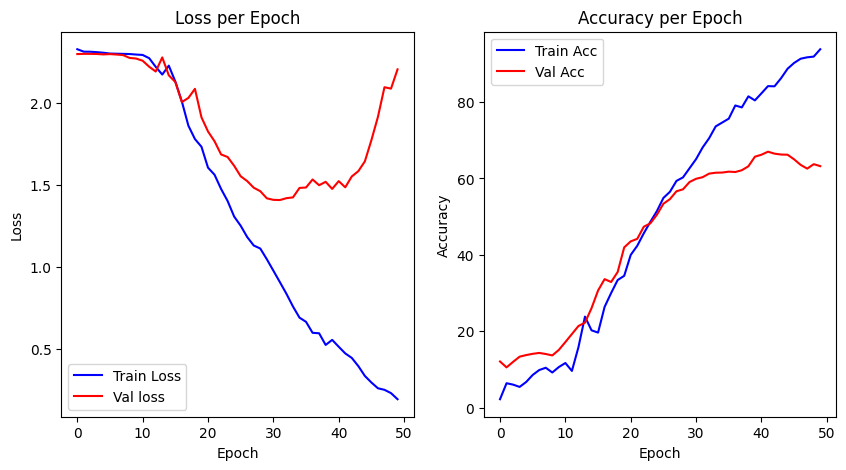

In [60]:
# tests for q3d

batch_size: int
num_epochs: int
learning_rate: float
example_hyper_parameter: int

# Define the hyperparameters
example_hyper_parameter = 1024 # example: this is how you should define the hyperparameters
batch_size = 32
num_epochs = 50
learning_rate = 5e-5

random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.backends.cudnn.deterministic = True

assert num_epochs <= 50, "num_epochs should be less than or equal to 50"

train_speech_commands_dataset = SpeechCommandDataset(
    path_to_speech_commands_dataset=PATH_TO_SPEECH_COMMANDS_DIR,
    path_to_txt_file=Path(PATH_TO_SPEECH_COMMANDS_DIR) / "training_list.txt",
    audio_sample_rate=16_000,
)
train_speech_commands_dataloader = DataLoader(
    dataset=train_speech_commands_dataset,
    collate_fn=speech_collate_fn,
    batch_size=batch_size,
    shuffle=True,
)

test_speech_commands_dataset = SpeechCommandDataset(
    path_to_speech_commands_dataset=PATH_TO_SPEECH_COMMANDS_DIR,
    path_to_txt_file=Path(PATH_TO_SPEECH_COMMANDS_DIR) / "testing_list.txt",
    audio_sample_rate=16_000,
)
test_speech_commands_dataloader = DataLoader(
    dataset=test_speech_commands_dataset,
    collate_fn=speech_collate_fn,
    batch_size=batch_size,
    shuffle=False,
)

cnn_model_speech_commands = CNN4SpeechCommands(in_channels=1, num_classes=10)

train(
    cnn_model_speech_commands,
    train_speech_commands_dataloader,
    test_speech_commands_dataloader,
    num_epochs=num_epochs,
    lr=learning_rate,
    plot_save_path=None,
)

<ipython-input-35-4be5a8019c38>:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = row[0]


Epoch [1/50]
Training Loss: 0.5392, Validation Loss: 0.3310
Training Accuracy: 80.67%
Validation Accuracy: 87.78%
Epoch [2/50]
Training Loss: 0.3230, Validation Loss: 0.2714
Training Accuracy: 88.40%
Validation Accuracy: 90.06%
Epoch [3/50]
Training Loss: 0.2726, Validation Loss: 0.2422
Training Accuracy: 90.09%
Validation Accuracy: 91.08%
Epoch [4/50]
Training Loss: 0.2408, Validation Loss: 0.2248
Training Accuracy: 91.20%
Validation Accuracy: 91.77%
Epoch [5/50]
Training Loss: 0.2180, Validation Loss: 0.2172
Training Accuracy: 92.13%
Validation Accuracy: 92.19%
Epoch [6/50]
Training Loss: 0.1998, Validation Loss: 0.2071
Training Accuracy: 92.73%
Validation Accuracy: 92.43%
Epoch [7/50]
Training Loss: 0.1836, Validation Loss: 0.2065
Training Accuracy: 93.28%
Validation Accuracy: 92.62%
Epoch [8/50]
Training Loss: 0.1704, Validation Loss: 0.1985
Training Accuracy: 93.89%
Validation Accuracy: 92.87%
Epoch [9/50]
Training Loss: 0.1571, Validation Loss: 0.2009
Training Accuracy: 94.24%
Va

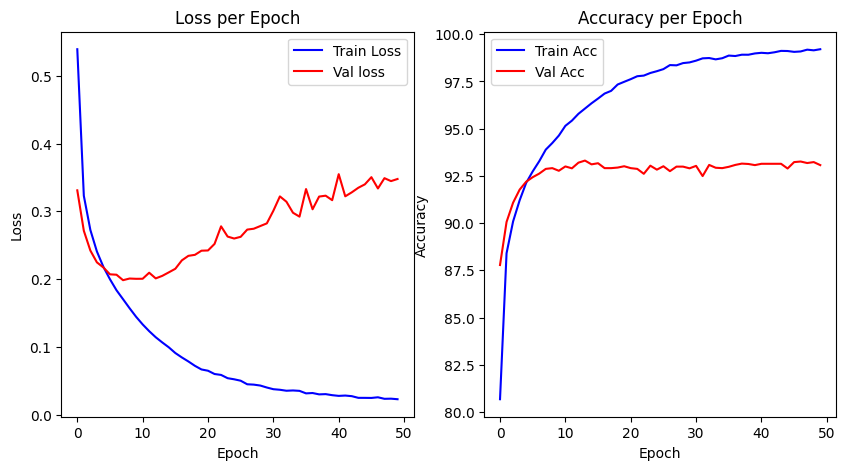

In [67]:
# tests for q3d

batch_size: int
num_epochs: int
learning_rate: float
example_hyper_parameter: int

# Define the hyperparameters
example_hyper_parameter = 1024 # example: this is how you should define the hyperparameters
batch_size = 32
num_epochs = 50
learning_rate = 5e-5

random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.backends.cudnn.deterministic = True

assert num_epochs <= 50, "num_epochs should be less than or equal to 50"

train_fashion_mnist_dataset = FashionMNISTDataset(
    csv_file_path=PATH_TO_FASHION_MNIST_DIR + "/fashion-mnist_train.csv"
)
train_fashion_mnist_dataloader = DataLoader(
    dataset=train_fashion_mnist_dataset,
    collate_fn=image_collate_fn,
    batch_size=batch_size,
    shuffle=True,
)

test_fashion_mnist_dataset = FashionMNISTDataset(
    csv_file_path=PATH_TO_FASHION_MNIST_DIR + "/fashion-mnist_test.csv"
)
test_fashion_mnist_dataloader = DataLoader(
    dataset=test_fashion_mnist_dataset,
    collate_fn=image_collate_fn,
    batch_size=batch_size,
    shuffle=False,
)

cnn_model_fashion_mnist = CNN4FashionMNIST(in_channels=1, num_classes=10)

train(
    cnn_model_fashion_mnist,
    train_fashion_mnist_dataloader,
    test_fashion_mnist_dataloader,
    num_epochs=num_epochs,
    lr=learning_rate,
    plot_save_path=None,
)

# `q4`: Bonus Question
* `q4a`: Implement a Feed Forward MLP for the `FashionMNIST` dataset using the Datasets, DataLoaders created in `q1`, and `train` function from `q2`. The network must have the following specifications:
  1. At least 500 `torch.nn.Linear` layers.
  2. Each `torch.nn.Linear` layer must have at least 300 units.

* `q4b`: Implement a Convolutional Neural Network for the `FashionMNIST` dataset using the Datasets, DataLoaders created in `q1`, and `train` function from `q2`. The network should have the following specifications:
  1. At least 500 `torch.nn.Conv2d` layers.
  2. Each `torch.nn.Conv2d` layer must have at least 32 output channels.

`q4` Grading [Total: 2 point]:
1. `q4a`: 1 point if your model achieves a validation accuracy of 80% or more, otherwise 0 points. No partial points for this question.
2. `q4b`: 1 point if your model achieves a validation accuracy of 80% or more, otherwise 0 points. No partial points for this question.

Please use the following cell to define the model classes for `q4a`, `q4b` and then to train the models. Do NOT create new cells.

In [62]:
# # YOUR CODE HERE
# class DeepFashionMNISTCNN(torch.nn.Module):
#     def __init__(self, num_classes=10, num_layers=500, channels_per_layer=32, input_size=28):
#         super(DeepFashionMNISTCNN, self).__init__()
#         self.num_layers = num_layers

#         layers = []
#         current_channels = 1  # Start with 1 input channel (grayscale images)
#         current_size = input_size

#         # First convolution layer
#         layers.append(torch.nn.Conv2d(current_channels, channels_per_layer, kernel_size=3, padding=1))
#         layers.append(torch.nn.BatchNorm2d(channels_per_layer))
#         layers.append(torch.nn.LeakyReLU())
#         layers.append(torch.nn.Dropout(p=0.25))

#         current_channels = channels_per_layer

#         # Add intermediate layers with residual blocks and standard convolutions
#         for i in range(num_layers - 1):
#             stride = 1
#             # Downsample every 10 layers
#             if (i + 1) % 10 == 0 and current_size > 2:
#                 stride = 2
#                 current_size //= 2

#             # Add a ResidualBlock every 3 layers
#             if i % 3 == 0:
#                 layers.append(ResidualBlock(current_channels, channels_per_layer, stride=stride))
#                 current_channels = channels_per_layer
#             else:
#                 layers.append(torch.nn.Conv2d(channels_per_layer, channels_per_layer, kernel_size=5, padding=2))
#                 # layers.append(torch.nn.BatchNorm2d(channels_per_layer))
#                 layers.append(torch.nn.LeakyReLU())
#                 layers.append(torch.nn.Dropout(p=0.5))

#         # Global Average Pooling + Fully Connected layer
#         self.conv_layers = torch.nn.Sequential(*layers)
#         self.fc = torch.nn.Linear(channels_per_layer, num_classes)

#     def forward(self, x):
#         x = self.conv_layers(x)  # Pass through all convolutional layers
#         x = torch.nn.functional.adaptive_avg_pool2d(x, 1).view(x.size(0), -1)  # Global average pooling
#         x = self.fc(x)  # Fully connected layer for classification
#         return x



# batch_size = 32
# num_epochs = 50
# learning_rate = 5e-5

# assert num_epochs <= 50, "num_epochs should be less than or equal to 50"

# train_fashion_mnist_dataset = FashionMNISTDataset(
#     csv_file_path=PATH_TO_FASHION_MNIST_DIR + "/fashion-mnist_train.csv"
# )
# train_fashion_mnist_dataloader = DataLoader(
#     dataset=train_fashion_mnist_dataset,
#     collate_fn=image_collate_fn,
#     batch_size=batch_size,
#     shuffle=True,
# )

# test_fashion_mnist_dataset = FashionMNISTDataset(
#     csv_file_path=PATH_TO_FASHION_MNIST_DIR + "/fashion-mnist_test.csv"
# )
# test_fashion_mnist_dataloader = DataLoader(
#     dataset=test_fashion_mnist_dataset,
#     collate_fn=image_collate_fn,
#     batch_size=batch_size,
#     shuffle=False,
# )

# cnn_model_fashion_mnist = DeepFashionMNISTCNN()

# train(
#     cnn_model_fashion_mnist,
#     train_fashion_mnist_dataloader,
#     test_fashion_mnist_dataloader,
#     num_epochs=num_epochs,
#     lr=learning_rate,
#     plot_save_path=None,
# )

<center>
    <h1 style="font-family: 'Garamond', serif; font-style: italic;">fin</h1>
</center>
